<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_stock_trading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog uses FinRL to reproduce the paper: Practical Deep Reinforcement Learning Approach for Stock Trading, Workshop on Challenges and Opportunities for AI in Financial Services, NeurIPS 2018.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-3fjrnc87
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-gmiuztqy/pyfolio_278168f2d7bc41b6b1716d0f3529ac3e



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [4]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [5]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [31]:
# Download and save the data in a pandas DataFrame:
df = YahooDownloader(start_date = '2009-01-01',
                          end_date = '2021-01-01',
                          ticker_list = ['AAPL', 'MSFT']).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (6042, 8)


In [32]:
df.shape

(6042, 8)

In [33]:
df.sort_values(['date','tic'],ignore_index=True).head(20)

date       open       high        low      close      volume   tic  \
0   2009-01-02   3.067143   3.251429   3.041429   2.787006   746015200  AAPL   
1   2009-01-02  19.530001  20.400000  19.370001  15.400049    50084000  MSFT   
2   2009-01-05   3.327500   3.435000   3.311071   2.904629  1181608400  AAPL   
3   2009-01-05  20.200001  20.670000  20.059999  15.543978    61475200  MSFT   
4   2009-01-06   3.426786   3.470357   3.299643   2.856720  1289310400  AAPL   
5   2009-01-06  20.750000  21.000000  20.610001  15.725779    58083400  MSFT   
6   2009-01-07   3.278929   3.303571   3.223571   2.794991   753048800  AAPL   
7   2009-01-07  20.190001  20.290001  19.480000  14.778899    72709900  MSFT   
8   2009-01-08   3.229643   3.326786   3.215714   2.846893   673500800  AAPL   
9   2009-01-08  19.629999  20.190001  19.549999  15.240969    70255400  MSFT   
10  2009-01-09   3.328929   3.335000   3.219286   2.781786   546845600  AAPL   
11  2009-01-09  20.170000  20.299999  19.410000  14.786469    49815300  MSFT   
12  2009-01-12   3.230714   3.249643   3.126786   2.722821   617716400  AAPL   
13  2009-01-12  19.709999  19.790001  19.299999  14.748591    52163500  MSFT   
14  2009-01-13   3.151429   3.205000   3.083929   2.693645   798397600  AAPL   
15  2009-01-13  19.520000  19.990000  19.520000  15.013720    65843500  MSFT   
16  2009-01-14   3.080000   3.116071   3.025714   2.620554  1021664000  AAPL   
17  2009-01-14  19.530001  19.680000  19.010000  14.460744    80257500  MSFT   
18  2009-01-15   2.877500   3.004286   2.858929   2.560668  1831634000  AAPL   
19  2009-01-15  19.070000  19.299999  18.520000  14.574368    96169800  MSFT   

    day  
0     4  
1     4  
2     0  
3     0  
4     1  
5     1  
6     2  
7     2  
8     3  
9     3  
10    4  
11    4  
12    0  
13    0  
14    1  
15    1  
16    2  
17    2  
18    3  
19    3

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [34]:
## we store the stockstats technical indicator column names in config.py
# tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
# print(tech_indicator_list)

In [35]:
## user can add more technical indicators
## check https://github.com/jealous/stockstats for different names
# tech_indicator_list=tech_indicator_list+['kdjk','open_2_sma','boll','close_10.0_le_5_c','wr_10','dma','trix']
# print(tech_indicator_list)

In [36]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [37]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [38]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

date   tic       open       high        low      close        volume  \
0  2009-01-02  AAPL   3.067143   3.251429   3.041429   2.787006  7.460152e+08   
1  2009-01-02  MSFT  19.530001  20.400000  19.370001  15.400049  5.008400e+07   
2  2009-01-05  AAPL   3.327500   3.435000   3.311071   2.904629  1.181608e+09   
3  2009-01-05  MSFT  20.200001  20.670000  20.059999  15.543978  6.147520e+07   
4  2009-01-06  AAPL   3.426786   3.470357   3.299643   2.856720  1.289310e+09   
5  2009-01-06  MSFT  20.750000  21.000000  20.610001  15.725779  5.808340e+07   
6  2009-01-07  AAPL   3.278929   3.303571   3.223571   2.794991  7.530488e+08   
7  2009-01-07  MSFT  20.190001  20.290001  19.480000  14.778899  7.270990e+07   
8  2009-01-08  AAPL   3.229643   3.326786   3.215714   2.846893  6.735008e+08   
9  2009-01-08  MSFT  19.629999  20.190001  19.549999  15.240969  7.025540e+07   

   day      macd    boll_ub    boll_lb      rsi_30     cci_30       dx_30  \
0  4.0  0.000000   3.012162   2.679473  100.000000  66.666667  100.000000   
1  4.0  0.000000   3.012162   2.679473  100.000000  66.666667  100.000000   
2  0.0  0.002639   3.012162   2.679473  100.000000  66.666667  100.000000   
3  0.0  0.003229  15.675559  15.268468  100.000000  66.666667  100.000000   
4  1.0  0.001877   2.967747   2.731157   70.355617  46.781839  100.000000   
5  1.0  0.009752  15.883064  15.230139  100.000000  98.711617  100.000000   
6  2.0 -0.000744   2.946720   2.724953   50.429326 -29.767280   43.607834   
7  2.0 -0.021707  16.184291  14.540061   24.678285 -87.952739   34.925807   
8  3.0 -0.000088   2.934583   2.741512   60.227078  -9.027798   48.357918   
9  3.0 -0.019957  16.058114  14.617756   45.428479 -49.650052   34.925807   

   close_30_sma  close_60_sma  turbulence  
0      2.787006      2.787006         0.0  
1     15.400049     15.400049         0.0  
2      2.845817      2.845817         0.0  
3     15.472013     15.472013         0.0  
4      2.849452      2.849452         0.0  
5     15.556602     15.556602         0.0  
6      2.835837      2.835837         0.0  
7     15.362176     15.362176         0.0  
8      2.838048      2.838048         0.0  
9     15.337935     15.337935         0.0

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [39]:
train = data_split(processed_full, '2009-01-01','2019-01-01')
trade = data_split(processed_full, '2019-01-01','2021-01-01')
print(len(train))
print(len(trade))

5032
1010


In [40]:
train.head()

date   tic       open       high        low      close        volume  \
0  2009-01-02  AAPL   3.067143   3.251429   3.041429   2.787006  7.460152e+08   
0  2009-01-02  MSFT  19.530001  20.400000  19.370001  15.400049  5.008400e+07   
1  2009-01-05  AAPL   3.327500   3.435000   3.311071   2.904629  1.181608e+09   
1  2009-01-05  MSFT  20.200001  20.670000  20.059999  15.543978  6.147520e+07   
2  2009-01-06  AAPL   3.426786   3.470357   3.299643   2.856720  1.289310e+09   

   day      macd    boll_ub    boll_lb      rsi_30     cci_30  dx_30  \
0  4.0  0.000000   3.012162   2.679473  100.000000  66.666667  100.0   
0  4.0  0.000000   3.012162   2.679473  100.000000  66.666667  100.0   
1  0.0  0.002639   3.012162   2.679473  100.000000  66.666667  100.0   
1  0.0  0.003229  15.675559  15.268468  100.000000  66.666667  100.0   
2  1.0  0.001877   2.967747   2.731157   70.355617  46.781839  100.0   

   close_30_sma  close_60_sma  turbulence  
0      2.787006      2.787006         0.0  
0     15.400049     15.400049         0.0  
1      2.845817      2.845817         0.0  
1     15.472013     15.472013         0.0  
2      2.849452      2.849452         0.0

In [41]:
trade.head()

date   tic        open        high        low      close  \
0  2019-01-02  AAPL   38.722500   39.712502  38.557499  38.439735   
0  2019-01-02  MSFT   99.550003  101.750000  98.940002  98.148849   
1  2019-01-03  AAPL   35.994999   36.430000  35.500000  34.610851   
1  2019-01-03  MSFT  100.099998  100.190002  97.199997  94.538162   
2  2019-01-04  AAPL   36.132500   37.137501  35.950001  36.088364   

        volume  day      macd     boll_ub    boll_lb     rsi_30      cci_30  \
0  148158800.0  2.0 -2.013469   44.430054  35.384485  37.867359  -91.575723   
0   35329300.0  2.0 -1.899983  109.976756  92.358201  45.769239  -81.414168   
1  365248800.0  3.0 -2.196012   43.837520  34.939350  32.751918 -177.955914   
1   42579100.0  3.0 -2.099707  108.967044  91.942076  42.780443 -114.373878   
2  234428400.0  4.0 -2.196139   43.381079  34.703769  36.192801 -139.723672   

       dx_30  close_30_sma  close_60_sma  turbulence  
0  42.250808     41.155815     46.409359    0.240223  
0  21.611852    101.954004    103.174837    0.240223  
1  55.246973     40.739255     46.079453   36.128578  
1  26.941934    101.601670    102.944353   36.128578  
2  47.060632     40.434177     45.776275    6.976028

In [42]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [43]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 2, State Space: 21


In [44]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [45]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [46]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [47]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [48]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=100000)

Logging to tensorboard_log/a2c/a2c_6
------------------------------------
| time/                 |          |
|    fps                | 120      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.96    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0187   |
|    std                | 1.06     |
|    value_loss         | 0.000468 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 161      |
|    iterations         | 200      |
|    time_elapsed       | 6        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.96    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|

------------------------------------
| time/                 |          |
|    fps                | 207      |
|    iterations         | 1500     |
|    time_elapsed       | 36       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | 0.000826 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1499     |
|    policy_loss        | -25.3    |
|    std                | 1.03     |
|    value_loss         | 158      |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.48e+06 |
|    total_cost         | 7.96e+03 |
|    total_reward       | 2.48e+06 |
|    total_reward_pct   | 248      |
|    total_trades       | 4072     |
| time/                 |          |
|    fps                | 209      |
|    iterations         | 1600     |
|    time_elapsed       | 38       |
|    total_timesteps    | 8000     |
|

------------------------------------
| time/                 |          |
|    fps                | 218      |
|    iterations         | 2900     |
|    time_elapsed       | 66       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -2.83    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 2899     |
|    policy_loss        | 0.774    |
|    std                | 0.998    |
|    value_loss         | 3.33     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 220      |
|    iterations         | 3000     |
|    time_elapsed       | 68       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -2.85    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 2999     |
|    policy_loss        | 19.5     |
|

------------------------------------
| time/                 |          |
|    fps                | 232      |
|    iterations         | 4300     |
|    time_elapsed       | 92       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -2.97    |
|    explained_variance | -0.0146  |
|    learning_rate      | 0.0007   |
|    n_updates          | 4299     |
|    policy_loss        | 7.79     |
|    std                | 1.07     |
|    value_loss         | 13.5     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 233      |
|    iterations         | 4400     |
|    time_elapsed       | 94       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -2.96    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4399     |
|    policy_loss        | -12.1    |
|

------------------------------------
| time/                 |          |
|    fps                | 239      |
|    iterations         | 5700     |
|    time_elapsed       | 118      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -3.04    |
|    explained_variance | 0.0912   |
|    learning_rate      | 0.0007   |
|    n_updates          | 5699     |
|    policy_loss        | 8.77     |
|    std                | 1.11     |
|    value_loss         | 5.1      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 240      |
|    iterations         | 5800     |
|    time_elapsed       | 120      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -3.04    |
|    explained_variance | -0.00543 |
|    learning_rate      | 0.0007   |
|    n_updates          | 5799     |
|    policy_loss        | 11.1     |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 3.76e+06  |
|    total_cost         | 1.05e+04  |
|    total_reward       | 2.76e+06  |
|    total_reward_pct   | 276       |
|    total_trades       | 4838      |
| time/                 |           |
|    fps                | 244       |
|    iterations         | 7100      |
|    time_elapsed       | 144       |
|    total_timesteps    | 35500     |
| train/                |           |
|    entropy_loss       | -3.08     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 7099      |
|    policy_loss        | -1.38     |
|    std                | 1.13      |
|    value_loss         | 0.287     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 245      |
|    iterations         | 7200     |
|    time_elapsed       | 146      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 248      |
|    iterations         | 8500     |
|    time_elapsed       | 171      |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -3.11    |
|    explained_variance | -0.00191 |
|    learning_rate      | 0.0007   |
|    n_updates          | 8499     |
|    policy_loss        | 12.3     |
|    std                | 1.15     |
|    value_loss         | 15.5     |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 4.95e+06  |
|    total_cost         | 8.77e+03  |
|    total_reward       | 3.95e+06  |
|    total_reward_pct   | 395       |
|    total_trades       | 4149      |
| time/                 |           |
|    fps                | 248       |
|    iterations         | 8600      |
|    time_elapsed       | 173       |
|    total_timesteps    | 4

------------------------------------
| time/                 |          |
|    fps                | 250      |
|    iterations         | 9900     |
|    time_elapsed       | 197      |
|    total_timesteps    | 49500    |
| train/                |          |
|    entropy_loss       | -3.15    |
|    explained_variance | 0.000277 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9899     |
|    policy_loss        | -10.2    |
|    std                | 1.17     |
|    value_loss         | 11.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 250      |
|    iterations         | 10000    |
|    time_elapsed       | 199      |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -3.16    |
|    explained_variance | -0.0044  |
|    learning_rate      | 0.0007   |
|    n_updates          | 9999     |
|    policy_loss        | 5.23     |
|

------------------------------------
| time/                 |          |
|    fps                | 252      |
|    iterations         | 11300    |
|    time_elapsed       | 223      |
|    total_timesteps    | 56500    |
| train/                |          |
|    entropy_loss       | -3.17    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 11299    |
|    policy_loss        | -28.1    |
|    std                | 1.18     |
|    value_loss         | 101      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 252      |
|    iterations         | 11400    |
|    time_elapsed       | 225      |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -3.18    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 11399    |
|    policy_loss        | 17.6     |
|

------------------------------------
| time/                 |          |
|    fps                | 252      |
|    iterations         | 12700    |
|    time_elapsed       | 250      |
|    total_timesteps    | 63500    |
| train/                |          |
|    entropy_loss       | -3.25    |
|    explained_variance | -0.00154 |
|    learning_rate      | 0.0007   |
|    n_updates          | 12699    |
|    policy_loss        | -8.88    |
|    std                | 1.23     |
|    value_loss         | 11.4     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 252      |
|    iterations         | 12800    |
|    time_elapsed       | 253      |
|    total_timesteps    | 64000    |
| train/                |          |
|    entropy_loss       | -3.27    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 12799    |
|    policy_loss        | -10.7    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 5.36e+06 |
|    total_cost         | 9.52e+03 |
|    total_reward       | 4.36e+06 |
|    total_reward_pct   | 436      |
|    total_trades       | 4873     |
| time/                 |          |
|    fps                | 246      |
|    iterations         | 14100    |
|    time_elapsed       | 286      |
|    total_timesteps    | 70500    |
| train/                |          |
|    entropy_loss       | -3.27    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 14099    |
|    policy_loss        | 0.0379   |
|    std                | 1.24     |
|    value_loss         | 0.00266  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 245      |
|    iterations         | 14200    |
|    time_elapsed       | 288      |
|    total_timesteps    | 71000    |
|

------------------------------------
| time/                 |          |
|    fps                | 241      |
|    iterations         | 15500    |
|    time_elapsed       | 321      |
|    total_timesteps    | 77500    |
| train/                |          |
|    entropy_loss       | -3.29    |
|    explained_variance | 0.00218  |
|    learning_rate      | 0.0007   |
|    n_updates          | 15499    |
|    policy_loss        | -8.63    |
|    std                | 1.26     |
|    value_loss         | 14.5     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.65e+06 |
|    total_cost         | 9.41e+03 |
|    total_reward       | 4.65e+06 |
|    total_reward_pct   | 465      |
|    total_trades       | 4995     |
| time/                 |          |
|    fps                | 241      |
|    iterations         | 15600    |
|    time_elapsed       | 323      |
|    total_timesteps    | 78000    |
|

------------------------------------
| time/                 |          |
|    fps                | 237      |
|    iterations         | 16900    |
|    time_elapsed       | 355      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -3.38    |
|    explained_variance | 0.000145 |
|    learning_rate      | 0.0007   |
|    n_updates          | 16899    |
|    policy_loss        | 0.866    |
|    std                | 1.32     |
|    value_loss         | 5.36     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 237      |
|    iterations         | 17000    |
|    time_elapsed       | 358      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -3.41    |
|    explained_variance | -0.00548 |
|    learning_rate      | 0.0007   |
|    n_updates          | 16999    |
|    policy_loss        | 25.3     |
|

------------------------------------
| time/                 |          |
|    fps                | 233      |
|    iterations         | 18300    |
|    time_elapsed       | 391      |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -3.46    |
|    explained_variance | 0.00295  |
|    learning_rate      | 0.0007   |
|    n_updates          | 18299    |
|    policy_loss        | -2.31    |
|    std                | 1.37     |
|    value_loss         | 1.59     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 233      |
|    iterations         | 18400    |
|    time_elapsed       | 393      |
|    total_timesteps    | 92000    |
| train/                |          |
|    entropy_loss       | -3.45    |
|    explained_variance | -0.0177  |
|    learning_rate      | 0.0007   |
|    n_updates          | 18399    |
|    policy_loss        | 2.45     |
|

day: 2515, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 5064811.02
total_reward: 4064811.02
total_cost: 11767.01
total_trades: 5002
Sharpe: 0.956
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.06e+06 |
|    total_cost         | 1.18e+04 |
|    total_reward       | 4.06e+06 |
|    total_reward_pct   | 406      |
|    total_trades       | 5002     |
| time/                 |          |
|    fps                | 231      |
|    iterations         | 19700    |
|    time_elapsed       | 425      |
|    total_timesteps    | 98500    |
| train/                |          |
|    entropy_loss       | -3.47    |
|    explained_variance | 0.348    |
|    learning_rate      | 0.0007   |
|    n_updates          | 19699    |
|    policy_loss        | 0.113    |
|    std                | 1.38     |
|    value_loss         | 1.18     |
------------------------------------
------------------------------------
| time/                 | 

### Model 2: DDPG

In [49]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [50]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_2
-----------------------------------
| environment/        |           |
|    portfolio_value  | 1e+06     |
|    total_cost       | 0         |
|    total_reward     | 0         |
|    total_reward_pct | 0         |
|    total_trades     | 0         |
| time/               |           |
|    episodes         | 4         |
|    fps              | 117       |
|    time_elapsed     | 85        |
|    total timesteps  | 10064     |
| train/              |           |
|    actor_loss       | -2.21e+04 |
|    critic_loss      | 2.57e+05  |
|    learning_rate    | 0.001     |
|    n_updates        | 7548      |
-----------------------------------
-----------------------------------
| environment/        |           |
|    portfolio_value  | 1e+06     |
|    total_cost       | 0         |
|    total_reward     | 0         |
|    total_reward_pct | 0         |
|    total_trades     | 0         |
| time/               |           |
|    episodes         | 8

### Model 3: PPO

In [57]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [58]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

Logging to tensorboard_log/ppo/ppo_2
-----------------------------
| time/              |      |
|    fps             | 107  |
|    iterations      | 1    |
|    time_elapsed    | 19   |
|    total_timesteps | 2048 |
-----------------------------


KeyboardInterrupt: ignored

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_2
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 33       |
|    time_elapsed    | 296      |
|    total timesteps | 10064    |
| train/             |          |
|    actor_loss      | 67.9     |
|    critic_loss     | 979      |
|    learning_rate   | 0.001    |
|    n_updates       | 7548     |
---------------------------------
day: 2515, episode: 10
begin_total_asset:1000000.00
end_total_asset:4438572.29
total_reward:3438572.29
total_cost: 1038.05
total_trades: 40290
Sharpe: 1.049
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 30       |
|    time_elapsed    | 669      |
|    total timesteps | 20128    |
| train/             |          |
|    actor_loss      | 54       |
|    critic_loss     | 199      |
|    learning_rate   | 0.001    |
|    n_updates       | 17612    |
------------------------

### Model 5: SAC

In [32]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [33]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=80000)

Logging to tensorboard_log/sac/sac_1
day: 2515, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3458901.03
total_reward: 2458901.03
total_cost: 184848.78
total_trades: 59497
Sharpe: 0.795
----------------------------------
| environment/        |          |
|    portfolio_value  | 3.46e+06 |
|    total_cost       | 1.85e+05 |
|    total_reward     | 2.46e+06 |
|    total_reward_pct | 246      |
|    total_trades     | 59497    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 25       |
|    time_elapsed     | 390      |
|    total timesteps  | 10064    |
| train/              |          |
|    actor_loss       | 802      |
|    critic_loss      | 561      |
|    ent_coef         | 0.217    |
|    ent_coef_loss    | -37.2    |
|    learning_rate    | 0.0001   |
|    n_updates        | 9963     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 4.59e+0

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [51]:
data_turbulence = processed_full[(processed_full.date<'2019-01-01') & (processed_full.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [52]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean        1.938672
std         4.514323
min         0.000000
25%         0.181132
50%         0.688860
75%         1.903499
max        85.823929
Name: turbulence, dtype: float64

In [53]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [54]:
turbulence_threshold

85.82392869517099

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [55]:
trade = data_split(processed_full, '2019-01-01','2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 45, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [56]:
trade

date   tic        open        high         low       close  \
0    2019-01-02  AAPL   38.722500   39.712502   38.557499   38.439735   
0    2019-01-02  MSFT   99.550003  101.750000   98.940002   98.148849   
1    2019-01-03  AAPL   35.994999   36.430000   35.500000   34.610851   
1    2019-01-03  MSFT  100.099998  100.190002   97.199997   94.538162   
2    2019-01-04  AAPL   36.132500   37.137501   35.950001   36.088364   
..          ...   ...         ...         ...         ...         ...   
502  2020-12-29  MSFT  226.309998  227.179993  223.580002  223.119720   
503  2020-12-30  AAPL  135.580002  135.990005  133.399994  133.294067   
503  2020-12-30  MSFT  225.229996  225.630005  221.470001  220.661072   
504  2020-12-31  AAPL  134.080002  134.740005  131.720001  132.267349   
504  2020-12-31  MSFT  221.699997  223.000000  219.679993  221.397675   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
0    148158800.0  2.0 -2.013469   44.430054   35.384485  37.867359   
0     35329300.0  2.0 -1.899983  109.976756   92.358201  45.769239   
1    365248800.0  3.0 -2.196012   43.837520   34.939350  32.751918   
1     42579100.0  3.0 -2.099707  108.967044   91.942076  42.780443   
2    234428400.0  4.0 -2.196139   43.381079   34.703769  36.192801   
..           ...  ...       ...         ...         ...        ...   
502   17403200.0  1.0  2.736602  225.408825  207.700256  56.729230   
503   96452100.0  2.0  3.978000  136.343761  117.343598  61.178812   
503   20272300.0  2.0  2.617854  225.841185  207.812380  54.777434   
504   99116600.0  3.0  3.853585  136.906108  117.739190  60.051021   
504   20942100.0  3.0  2.553744  226.336227  208.019098  55.254563   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
0    -91.575723  42.250808     41.155815     46.409359    0.240223  
0    -81.414168  21.611852    101.954004    103.174837    0.240223  
1   -177.955914  55.246973     40.739255     46.079453   36.128578  
1   -114.373878  26.941934    101.601670    102.944353   36.128578  
2   -139.723672  47.060632     40.434177     45.776275    6.976028  
..          ...        ...           ...           ...         ...  
502  175.970254  30.484308    215.096200    213.695440    0.554162  
503  138.864404  38.845768    123.664505    119.857089    0.215174  
503  121.194903  20.796775    215.262672    213.892021    0.215174  
504  109.888458  30.069064    124.106426    120.184790    0.561844  
504   90.082420  13.176882    215.545367    214.174843    0.561844  

[1010 rows x 17 columns]

In [57]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

         date   tic        open        high        low      close  \
1  2019-01-03  AAPL   35.994999   36.430000  35.500000  34.610851   
1  2019-01-03  MSFT  100.099998  100.190002  97.199997  94.538162   

        volume  day      macd     boll_ub    boll_lb     rsi_30      cci_30  \
1  365248800.0  3.0 -2.196012   43.837520  34.939350  32.751918 -177.955914   
1   42579100.0  3.0 -2.099707  108.967044  91.942076  42.780443 -114.373878   

       dx_30  close_30_sma  close_60_sma  turbulence  
1  55.246973     40.739255     46.079453   36.128578  
1  26.941934    101.601670    102.944353   36.128578  
         date   tic       open        high        low      close       volume  \
2  2019-01-04  AAPL  36.132500   37.137501  35.950001  36.088364  234428400.0   
2  2019-01-04  MSFT  99.720001  102.510002  98.930000  98.935059   44060600.0   

   day      macd     boll_ub    boll_lb     rsi_30      cci_30      dx_30  \
2  4.0 -2.196139   43.381079  34.703769  36.192801 -139.723672  47.0

          date   tic        open        high         low       close  \
22  2019-02-04  AAPL   41.852501   42.915001   41.820000   41.684422   
22  2019-02-04  MSFT  102.870003  105.800003  102.769997  102.633110   

         volume  day      macd     boll_ub    boll_lb     rsi_30      cci_30  \
22  125982000.0  0.0  0.283757   41.069217  35.043256  51.303633  241.505483   
22   31315100.0  0.0  0.275423  105.072860  98.262807  50.668273   52.126351   

        dx_30  close_30_sma  close_60_sma  turbulence  
22  26.070856     37.785277     40.891474    2.565411  
22   3.719938    100.068417    102.071664    2.565411  
          date   tic        open        high         low       close  \
23  2019-02-05  AAPL   43.215000   43.770000   43.087502   42.397625   
23  2019-02-05  MSFT  106.059998  107.269997  105.959999  104.069618   

         volume  day      macd     boll_ub    boll_lb     rsi_30      cci_30  \
23  144406400.0  1.0  0.517535   41.801069  34.950363  52.782282  256.960321 

          date   tic        open        high         low       close  \
43  2019-03-06  AAPL   43.667500   43.872501   43.485001   42.662579   
43  2019-03-06  MSFT  111.870003  112.660004  111.430000  108.929749   

        volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
43  83241600.0  2.0  0.758285   43.195012   41.149279  53.265090   72.419472   
43  17687000.0  2.0  1.913315  111.981811  100.423981  56.726086  109.326995   

        dx_30  close_30_sma  close_60_sma  turbulence  
43  31.719749     41.250936     39.754745    0.167434  
43  22.074175    104.923995    102.636622    0.167434  
          date   tic        open        high         low       close  \
44  2019-03-07  AAPL   43.467499   43.610001   43.005001   42.168774   
44  2019-03-07  MSFT  111.400002  111.550003  109.870003  107.604065   

        volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
44  99185600.0  3.0  0.681263   43.176585   41.143361  51.564660  50.453567   

          date   tic        open        high         low       close  \
65  2019-04-05  AAPL   49.112499   49.275002   48.982498   48.157959   
65  2019-04-05  MSFT  119.389999  120.230003  119.370003  116.864326   

        volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
65  74106400.0  4.0  1.292933   48.639899   43.671580  64.242717  119.631117   
65  15826200.0  4.0  2.179023  118.478005  110.211117  62.291103  103.218994   

        dx_30  close_30_sma  close_60_sma  turbulence  
65  46.582503     44.972284     42.408296    0.098044  
65  36.627184    112.532801    107.727559    0.098044  
          date   tic        open        high         low       close  \
66  2019-04-08  AAPL   49.105000   50.057499   49.084999   48.915783   
66  2019-04-08  MSFT  119.809998  120.019997  118.639999  116.903313   

         volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
66  103526800.0  0.0  1.361671   48.916198   43.913530  66.009178  131.01490

          date   tic        open        high       low       close  \
87  2019-05-08  AAPL   50.474998   51.334999   50.4375   49.600250   
87  2019-05-08  MSFT  125.440002  126.370003  124.7500  122.342491   

         volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
87  105358000.0  2.0  0.916092   51.842681   47.983639  58.117915  35.554722   
87   28419000.0  2.0  2.311556  128.971780  115.130291  59.728605  44.864967   

        dx_30  close_30_sma  close_60_sma  turbulence  
87   2.501521     49.083963      46.33077    0.009818  
87  13.070928    119.977065     114.84423    0.009818  
          date   tic        open        high         low       close  \
88  2019-05-09  AAPL   50.099998   50.419998   49.165001   49.067337   
88  2019-05-09  MSFT  124.290001  125.790001  123.570000  122.332741   

         volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
88  139634400.0  3.0  0.760147   51.841611   47.987153  56.152396 -18.525403   
88 

           date   tic        open        high         low       close  \
109  2019-06-10  AAPL   47.952499   48.842499   47.904999   47.258759   
109  2019-06-10  MSFT  132.399994  134.080002  132.000000  129.732025   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
109  104883600.0  0.0 -0.583910   47.804472   42.204833  53.103576   
109   26477100.0  0.0  1.117734  129.120242  117.874935  61.552659   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
109   19.018223   3.302644     46.704375     47.321978    0.422386  
109  228.335420  26.439972    123.764672    120.554127    0.422386  
           date   tic        open        high         low       close  \
110  2019-06-11  AAPL   48.715000   49.000000   48.400002   47.805996   
110  2019-06-11  MSFT  133.880005  134.240005  131.279999  129.242813   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
110  107731600.0  1.0 -0.338321   48.177257   42.055114  54.451376   
11

           date   tic        open        high         low       close  \
130  2019-07-10  AAPL   50.462502   50.932499   50.389999   49.872242   
130  2019-07-10  MSFT  137.130005  138.580002  137.020004  134.868484   

         volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
130  71588400.0  2.0  0.785771   50.520219   47.112623  57.528427  83.742277   
130  24204400.0  2.0  2.161380  136.297190  128.369796  62.747223  92.523376   

         dx_30  close_30_sma  close_60_sma  turbulence  
130  12.929038     47.505300     47.894216    0.309762  
130  27.373695    129.545463    126.346533    0.309762  
           date   tic        open        high         low       close  \
131  2019-07-11  AAPL   50.827499   51.097500   50.427502   49.509064   
131  2019-07-11  MSFT  138.199997  139.220001  137.869995  135.406570   

         volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
131  80767200.0  3.0  0.750052   50.547216   47.271147  56.211460  

           date   tic        open        high         low       close  \
151  2019-08-08  AAPL   50.049999   50.882500   49.847500   49.921326   
151  2019-08-08  MSFT  136.600006  138.990005  135.929993  135.885956   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
151  108038000.0  3.0  0.057085   52.592443   48.041863  52.748734 -38.432227   
151   27496500.0  3.0  0.265716  139.540181  130.278905  56.752350  22.814609   

        dx_30  close_30_sma  close_60_sma  turbulence  
151  1.454777     50.042225     48.136791    2.420603  
151  7.543532    134.441230    130.627378    2.420603  
           date   tic        open        high         low       close  \
152  2019-08-09  AAPL   50.325001   50.689999   49.822498   49.509953   
152  2019-08-09  MSFT  138.610001  139.380005  136.460007  134.731506   

         volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
152  98478800.0  4.0  0.025671   52.594718   48.001642  51.597914 -5

           date   tic        open        high         low       close  \
167  2019-08-30  AAPL   52.540001   52.612499   51.799999   51.419014   
167  2019-08-30  MSFT  139.149994  139.179993  136.270004  135.327377   

         volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
167  84573600.0  4.0  0.338376   53.091356   47.746943  54.198430  48.649941   
167  23940100.0  4.0  0.155890  137.578805  129.635979  53.811728  24.720282   

        dx_30  close_30_sma  close_60_sma  turbulence  
167  8.244008     50.655170     49.795612    0.037896  
167  2.013171    134.486928    133.509678    0.037896  
           date   tic        open        high         low       close  \
168  2019-09-03  AAPL   51.607498   51.744999   51.055000   50.670170   
168  2019-09-03  MSFT  136.610001  137.199997  135.699997  133.540802   

         volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
168  80092000.0  1.0  0.289509   52.856924   48.303866  52.231326  -7.3

           date   tic        open        high         low       close  \
183  2019-09-24  AAPL   55.257500   55.622501   54.297501   53.621204   
183  2019-09-24  MSFT  140.360001  140.690002  136.880005  134.856216   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
183  124763200.0  1.0  0.860870   56.091893   49.919608  56.155024  78.306624   
183   29773200.0  1.0  0.532535  138.134138  132.199619  51.712175  54.120653   

         dx_30  close_30_sma  close_60_sma  turbulence  
183  25.013739     52.374201     51.230035    0.872222  
183   4.718847    134.710260    134.663636    0.872222  
           date   tic        open        high         low       close  \
184  2019-09-25  AAPL   54.637501   55.375000   54.285000   54.446419   
184  2019-09-25  MSFT  137.500000  139.960007  136.029999  136.799820   

         volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
184  87613600.0  2.0  0.856175   56.081926   50.345135  58.053486

           date   tic        open        high         low       close  \
204  2019-10-23  AAPL   60.525002   60.810001   60.305000   59.902634   
204  2019-10-23  MSFT  136.880005  137.449997  135.610001  134.718796   

         volume  day      macd    boll_ub     boll_lb     rsi_30      cci_30  \
204  75828800.0  2.0  1.514364   60.45147   52.854372  66.235885  160.014053   
204  29844600.0  2.0  0.086259  138.97817  132.236113  50.139899  -83.450284   

         dx_30  close_30_sma  close_60_sma  turbulence  
204  46.264048     55.843766     53.427887    0.445128  
204   1.688196    135.673238    134.825628    0.445128  
           date   tic        open        high         low       close  \
205  2019-10-24  AAPL   61.127499   61.200001   60.452499   60.001167   
205  2019-10-24  MSFT  139.389999  140.419998  138.669998  137.369171   

         volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
205  69275200.0  3.0  1.564074   60.834198   53.055201  66.424115  

           date   tic        open        high         low       close  \
226  2019-11-22  AAPL   65.647499   65.794998   65.209999   64.677971   
226  2019-11-22  MSFT  150.070007  150.300003  148.820007  147.341553   

         volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
226  65325200.0  4.0  1.780746   67.469430   60.092741  67.088549   68.359252   
226  15901800.0  4.0  2.612760  149.263388  138.498890  62.655814  115.550130   

         dx_30  close_30_sma  close_60_sma  turbulence  
226  21.910652     62.153752     58.192971     0.02364  
226  38.966834    141.446751    138.391972     0.02364  
           date   tic        open        high         low       close  \
227  2019-11-25  AAPL   65.677498   66.610001   65.629997   65.812027   
227  2019-11-25  MSFT  150.000000  151.350006  149.919998  148.956894   

         volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
227  84020400.0  0.0  1.747072   67.612144   60.396369  69.28667

           date   tic        open        high         low       close  \
249  2019-12-27  AAPL   72.779999   73.492500   72.029999   71.600876   
249  2019-12-27  MSFT  159.449997  159.550003  158.220001  156.570709   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
249  146266000.0  4.0  1.846890   72.291948   63.327731  72.628438   
249   18412800.0  4.0  2.777039  157.676831  145.088929  69.543357   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
249  178.737325  61.657373     67.008592     63.506758    0.050977  
249  162.890290  46.686622    150.203197    144.438149    0.050977  
           date   tic        open        high         low       close  \
250  2019-12-30  AAPL   72.364998   73.172501   71.305000   72.025833   
250  2019-12-30  MSFT  158.990005  159.020004  156.729996  155.221313   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
250  144114400.0  0.0  1.917445   72.883075   63.336242  73.303153   
25

           date   tic        open        high         low       close  \
272  2020-01-31  AAPL   80.232498   80.669998   77.072502   76.470634   
272  2020-01-31  MSFT  172.210007  172.399994  169.580002  167.671310   

          volume  day      macd     boll_ub     boll_lb    rsi_30      cci_30  \
272  199588400.0  4.0  2.055451   81.127330   73.288693  60.94594   51.157103   
272   36142700.0  4.0  3.349234  169.452778  153.948088  65.59621  155.365722   

         dx_30  close_30_sma  close_60_sma  turbulence  
272   8.807090     75.130605     70.385422   10.954725  
272  37.401417    159.538098    153.489452   10.954725  
           date   tic        open        high         low       close  \
273  2020-02-03  AAPL   76.074997   78.372498   75.555000   76.260628   
273  2020-02-03  MSFT  170.429993  174.500000  170.399994  171.758942   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
273  173788400.0  0.0  1.775149   80.889695   73.803789  60.431565   
273  

           date   tic        open        high         low       close  \
294  2020-03-04  AAPL   74.110001   75.849998   73.282501   74.975479   
294  2020-03-04  MSFT  168.490005  170.699997  165.619995  168.445358   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
294  219178400.0  2.0 -1.373837   85.235700   67.716093  51.650204 -62.892576   
294   49814400.0  2.0 -1.026532  193.300908  156.774443  52.159015 -44.988879   

         dx_30  close_30_sma  close_60_sma  turbulence  
294  21.628268     77.067193     74.633609    7.521364  
294  16.305525    172.203010    164.026691    7.521364  
           date   tic        open        high         low       close  \
295  2020-03-05  AAPL   73.879997   74.887497   72.852501   72.543495   
295  2020-03-05  MSFT  166.050003  170.869995  165.690002  164.218155   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
295  187572800.0  3.0 -1.377979   84.944885   67.319193  48.7551

           date   tic        open        high         low       close  \
317  2020-04-06  AAPL   62.724998   65.777496   62.345001   65.002357   
317  2020-04-06  MSFT  160.320007  166.500000  157.580002  163.230530   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
317  201820400.0  0.0 -2.356340   69.696028   54.738908  47.942662 -16.780455   
317   67111700.0  0.0 -1.042793  165.806306  130.131076  52.131216  69.320197   

         dx_30  close_30_sma  close_60_sma  turbulence  
317   5.097837     65.142702     71.840308   12.199266  
317  19.847529    152.793902    162.173981   12.199266  
           date   tic        open        high         low       close  \
318  2020-04-07  AAPL   67.699997   67.925003   64.750000   64.249489   
318  2020-04-07  MSFT  169.589996  170.000000  163.259995  161.472458   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
318  202887200.0  1.0 -2.010159   68.326007   55.467252  47.4015

           date   tic        open        high         low      close  \
340  2020-05-08  AAPL   76.410004   77.587502   76.072502   77.01358   
340  2020-05-08  MSFT  184.979996  185.000000  183.360001  182.40097   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
340  133838400.0  4.0  2.321033   76.385087   65.572267  57.609505   
340   30877800.0  4.0  5.325212  183.682113  163.439730  56.999182   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
340  146.992464  39.029937     68.287768     68.685795    2.139977  
340  121.832926  27.451494    167.983116    163.381853    2.139977  
           date   tic        open        high         low       close  \
341  2020-05-11  AAPL   77.025002   79.262497   76.809998   78.225410   
341  2020-05-11  MSFT  183.149994  187.509995  182.850006  184.435562   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
341  145946400.0  0.0  2.589726   77.573546   65.439139  58.614136   
341  

           date   tic        open        high         low       close  \
361  2020-06-09  AAPL   83.035004   86.402496   83.002502   85.421921   
361  2020-06-09  MSFT  188.000000  190.699997  187.259995  187.979889   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
361  147712400.0  1.0  2.661770   83.813817   74.916397  64.430343   
361   29783900.0  1.0  3.052932  187.140047  176.683238  58.233142   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
361  174.235187  59.994048     77.437151     70.946138    3.927695  
361  166.785277  31.071541    180.474085    168.934088    3.927695  
           date   tic        open        high         low       close  \
362  2020-06-10  AAPL   86.974998   88.692497   86.522499   87.619614   
362  2020-06-10  MSFT  191.130005  198.520004  191.009995  194.952362   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
362  166651600.0  2.0  2.999443   85.549680   74.209353  66.408987   
36

           date   tic        open        high         low       close  \
380  2020-07-07  AAPL   93.852501   94.654999   93.057503   92.548889   
380  2020-07-07  MSFT  210.449997  214.669998  207.990005  206.252930   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
380  112424400.0  1.0  3.062615   93.777332   83.153245  64.558736   
380   33600700.0  1.0  5.874043  209.455021  182.521641  61.983164   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
380  121.448737  41.887967     85.701950     79.483082    0.551376  
380  153.078999  47.129113    191.391177    183.761226    0.551376  
           date   tic        open        high         low       close  \
381  2020-07-08  AAPL   94.180000   95.375000   94.089996   94.704369   
381  2020-07-08  MSFT  210.070007  213.259995  208.690002  210.789032   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
381  117092000.0  2.0  3.213008   94.722154   83.136668  66.460861   
38

           date   tic        open        high         low       close  \
402  2020-08-06  AAPL  110.404999  114.412498  109.797501  113.140152   
402  2020-08-06  MSFT  212.339996  216.369995  211.550003  214.275269   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
402  202428800.0  3.0  4.962839  111.561484   85.633797  73.431830   
402   32656800.0  3.0  3.168232  215.721882  196.073876  59.841975   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
402  242.032879  60.956266     96.227858     89.260390    2.375137  
402  117.646625  28.104559    205.130805    195.512887    2.375137  
           date   tic        open        high         low       close  \
403  2020-08-07  AAPL  113.205002  113.675003  110.292503  110.567833   
403  2020-08-07  MSFT  214.850006  215.699997  210.929993  210.442368   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
403  198045600.0  4.0  5.201358  113.270611   85.453652  69.673654   
40

           date   tic        open        high         low       close  \
420  2020-09-01  AAPL  132.759995  134.800003  130.529999  133.522247   
420  2020-09-01  MSFT  225.509995  227.449997  224.429993  225.634674   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
420  151948100.0  1.0  7.461613  132.663974  104.017036  76.649710   
420   25725500.0  1.0  5.255935  227.905517  198.383970  62.189849   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
420  152.423038  72.619958    111.569745    101.256978    4.763865  
420  168.381741  43.738478    210.245306    204.974993    4.763865  
           date   tic        open        high         low       close  \
421  2020-09-02  AAPL  137.589996  137.979996  127.000000  130.755875   
421  2020-09-02  MSFT  227.970001  232.860001  227.350006  229.983139   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
421  200119000.0  2.0  7.508274  134.097720  104.726292  72.972421   
42

           date   tic        open        high         low       close  \
441  2020-10-01  AAPL  117.639999  117.720001  115.830002  116.217491   
441  2020-10-01  MSFT  213.490005  213.990005  211.320007  210.931229   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
441  116120400.0  3.0 -0.316266  120.720731  105.051073  55.324099 -11.054252   
441   27158400.0  3.0 -0.838183  214.551188  196.319921  52.698399   6.172613   

        dx_30  close_30_sma  close_60_sma  turbulence  
441  2.950958    117.193599    109.998041    0.106878  
441  4.716713    210.386506    208.443970    0.106878  
           date   tic        open        high         low       close  \
442  2020-10-02  AAPL  112.889999  115.370003  112.220001  112.465973   
442  2020-10-02  MSFT  208.000000  210.990005  205.539993  204.706360   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
442  144712000.0  4.0 -0.348879  119.512272  105.477385  52.477623 

           date   tic        open        high         low       close  \
462  2020-10-30  AAPL  111.059998  111.989998  107.720001  108.326363   
462  2020-10-30  MSFT  203.500000  204.289993  199.619995  201.013123   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
462  190272600.0  4.0 -0.691916  123.056776  108.928422  47.218013   
462   36953700.0  4.0 -1.263239  223.884424  199.540707  46.228425   

         cci_30      dx_30  close_30_sma  close_60_sma  turbulence  
462 -130.857762  27.158149    114.617373    116.085599   10.054106  
462 -117.008803  39.050370    209.553876    210.256226   10.054106  
           date   tic        open        high         low       close  \
463  2020-11-02  AAPL  109.110001  110.680000  107.320000  108.236809   
463  2020-11-02  MSFT  204.289993  205.279999  200.119995  200.874115   

          volume  day      macd     boll_ub     boll_lb     rsi_30  \
463  122866900.0  0.0 -1.111685  123.478354  107.737635  47.158560   
46

           date   tic        open        high         low       close  \
483  2020-12-01  AAPL  121.010002  123.470001  120.010002  122.329109   
483  2020-12-01  MSFT  214.509995  217.320007  213.350006  215.216232   

          volume  day      macd     boll_ub     boll_lb     rsi_30     cci_30  \
483  127728200.0  1.0  0.805367  122.558500  111.680689  56.468019  158.89479   
483   30904500.0  1.0  0.571312  221.593932  205.478706  52.650752   47.02439   

         dx_30  close_30_sma  close_60_sma  turbulence  
483  18.326968    115.925628    115.000170    1.888389  
483   2.171534    211.724791    209.847075    1.888389  
           date   tic        open        high         low       close  \
484  2020-12-02  AAPL  122.019997  123.370003  120.889999  122.687958   
484  2020-12-02  MSFT  214.880005  215.470001  212.800003  214.380066   

         volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
484  89004200.0  2.0  1.153835  122.597480  112.920642  56.73014

           date   tic        open        high         low       close  \
504  2020-12-31  AAPL  134.080002  134.740005  131.720001  132.267349   
504  2020-12-31  MSFT  221.699997  223.000000  219.679993  221.397675   

         volume  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
504  99116600.0  3.0  3.853585  136.906108  117.739190  60.051021  109.888458   
504  20942100.0  3.0  2.553744  226.336227  208.019098  55.254563   90.082420   

         dx_30  close_30_sma  close_60_sma  turbulence  
504  30.069064    124.106426    120.184790    0.561844  
504  13.176882    215.545367    214.174843    0.561844  
hit end!


In [58]:
df_account_value.shape

(505, 2)

In [59]:
df_account_value.tail()

date  account_value
500  2020-12-24   1.989996e+06
501  2020-12-28   2.028003e+06
502  2020-12-29   2.013269e+06
503  2020-12-30   1.993299e+06
504  2020-12-31   1.991878e+06

In [61]:
df_actions

AAPL  MSFT
date                  
2019-01-02   100   100
2019-01-03   100   100
2019-01-04   100   100
2019-01-07   100   100
2019-01-08   100   100
...          ...   ...
2020-12-23    43   100
2020-12-24  -100  -100
2020-12-28   100   100
2020-12-29  -100  -100
2020-12-30   -90   100

[504 rows x 2 columns]

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [62]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.410377
Cumulative returns     0.991878
Annual volatility      0.246153
Sharpe ratio           1.522927
Calmar ratio           1.634596
Stability              0.959253
Max drawdown          -0.251057
Omega ratio            1.364730
Sortino ratio          2.272921
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.917044
Daily value at risk   -0.029525
dtype: float64


In [66]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker=["AAPL", "MSFT"], 
        start = '2019-01-01',
        end = '2021-01-01')

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  2 of 2 completed


ValueError: Length of values (2) does not match length of index (505)

In [64]:
baseline_df

date        open        high         low       close     volume  \
0    2019-01-02   38.722500   39.712502   38.557499   38.439735  148158800   
1    2019-01-03   35.994999   36.430000   35.500000   34.610851  365248800   
2    2019-01-04   36.132500   37.137501   35.950001   36.088364  234428400   
3    2019-01-07   37.174999   37.207500   36.474998   36.008041  219111200   
4    2019-01-08   37.389999   37.955002   37.130001   36.694466  164101200   
..          ...         ...         ...         ...         ...        ...   
500  2020-12-24  131.320007  133.460007  131.100006  131.549637   54930100   
501  2020-12-28  133.990005  137.339996  133.509995  136.254608  124486200   
502  2020-12-29  138.050003  138.789993  134.339996  134.440399  121047300   
503  2020-12-30  135.580002  135.990005  133.399994  133.294067   96452100   
504  2020-12-31  134.080002  134.740005  131.720001  132.267349   99116600   

      tic  day  
0    AAPL    2  
1    AAPL    3  
2    AAPL    4  
3    AAPL    0  
4    AAPL    1  
..    ...  ...  
500  AAPL    3  
501  AAPL    0  
502  AAPL    1  
503  AAPL    2  
504  AAPL    3  

[505 rows x 8 columns]

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


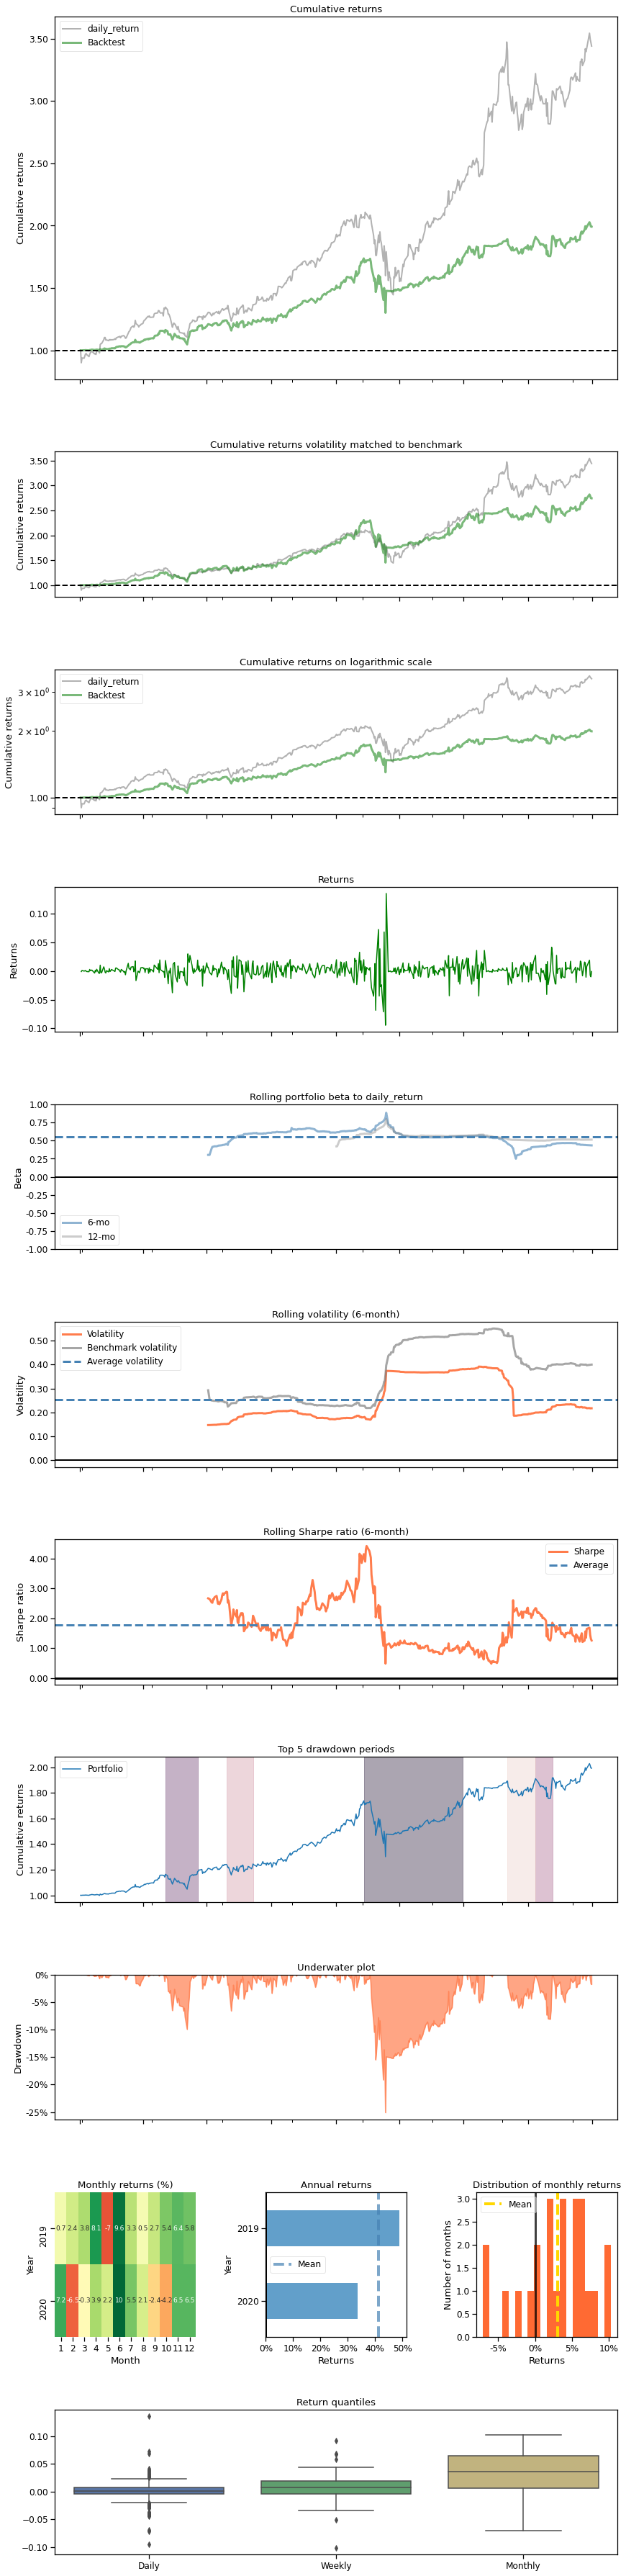

In [65]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = 'AAPL', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')